# S-matrix validation with `jwave`
This notebook attempts to validate the S-matrix method of ultrasound simulation against a 1-D `jwave` simulation. 

In [1]:
import time

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import skrf as rf # RF engineering tools useful for working with S-matrix

from logzero import logger
from tqdm.auto import tqdm

import scipy.signal as spsig
import numpy.fft as npft

# jwave imports
import jax.numpy as jnp
from jax import jit
from jwave import FourierSeries
from jwave.utils import show_field
import jax
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *

import itertools as itools
import functools as ftools

import Pulse as pulse
import plotutils as put
import smatrix as smat

import ipywidgets as widgets
from ipywidgets import interactive

In [2]:
# np.random.seed( 42 )
%matplotlib widget

In [3]:
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update( 'jax_enable_x64', False )

# Simulation parameters
Ideally, you shouldn't have to change anything outside the following cell. 

In [4]:
# all units in SI unless mentioned otherwise.

soc = 0.3 # state of charge
domain_size_lam = 15 # in terms of number of pulse wavelengths
padding_fraction = 0.1
num_points_along_largest_dimension = 7000
cfl = 0.3 # Courant factor

materials = [ 'oil', 'steel', 'roll', 'anode', 'electrolyte', 'cathode', 'core' ]
speeds = [ 1440., 5500., 1041.865, (1.-soc)*1341. + soc*1443., 1497., (1.-soc)*1093. + soc*1136., 3410. ]
densities = [ 870., 7850., 1933.949, (1.-soc)*1909. + soc*1994., 1000., (1.-soc)*4172. + soc*3848., 0.129 ] 

stack_thickness = 7.5e-3
# stack_definition = [ 0, 2, 3, 2, 3, 2, 3, 0 ]
# stack_definition = [ 0, 3, 0 ]
# stack_definition = [ 0, 3, 2, 0 ]
# stack_definition = [ 0, 3, 2, 3, 2, 0 ]
# stack_definition = [ 0, 2, 3, 5, 4, 3, 2, 4, 0 ]
stack_definition = [ 0, 2, 3, 5, 4, 3, 2, 4, 5, 3, 5, 2, 4, 3, 4, 0 ]


field = 'pressure' # physical field to simulate, options are 'pressure' and 'velocity'
pulse_frequency = 1.e6 # Hz
simulation_time = 100.e-6 # seconds
pulse_order = 15

pulse_spatial_location = -17.5e-3

store_full_simulation = True

In [5]:
material_properties = { key: [ val1, val2 ] for key, val1, val2 in zip( materials, speeds, densities ) }
reflectivity = { 
    key: ( np.prod( material_properties[ key[0] ] ) - np.prod( material_properties[ key[1] ] ) ) / ( np.prod( material_properties[ key[0] ] ) + np.prod( material_properties[ key[1] ] ) )
    for key in list( itools.combinations( materials, 2 ) )
}

In [6]:
material_properties

{'oil': [1440.0, 870.0],
 'steel': [5500.0, 7850.0],
 'roll': [1041.865, 1933.949],
 'anode': [1371.6, 1934.5],
 'electrolyte': [1497.0, 1000.0],
 'cathode': [1105.8999999999999, 4074.7999999999993],
 'core': [3410.0, 0.129]}

In [7]:
reflectivity

{('oil', 'steel'): np.float64(-0.9436028792782897),
 ('oil', 'roll'): np.float64(-0.23322537632960863),
 ('oil', 'anode'): np.float64(-0.3585516538722605),
 ('oil', 'electrolyte'): np.float64(-0.0888064586515383),
 ('oil', 'cathode'): np.float64(-0.5649336312297029),
 ('oil', 'core'): np.float64(0.9992979955338002),
 ('steel', 'roll'): np.float64(0.9108246240556087),
 ('steel', 'anode'): np.float64(0.8842044450894404),
 ('steel', 'electrolyte'): np.float64(0.9329781518624641),
 ('steel', 'cathode'): np.float64(0.8109816928202526),
 ('steel', 'core'): np.float64(0.9999796231375466),
 ('roll', 'anode'): np.float64(-0.13676284394399266),
 ('roll', 'electrolyte'): np.float64(0.14747337437177244),
 ('roll', 'cathode'): np.float64(-0.3820453501314744),
 ('roll', 'core'): np.float64(0.999563461234954),
 ('anode', 'electrolyte'): np.float64(0.27861682945012817),
 ('anode', 'cathode'): np.float64(-0.2588049642744443),
 ('anode', 'core'): np.float64(0.9996684829413808),
 ('electrolyte', 'cathode

# Spatial domain

In [8]:
# calculating domain size
lam_all = [ s/pulse_frequency for s in speeds ]
lam_max = max(  lam_all )  # maximum wavelength
lam_min = min( lam_all )  # maximum wavelength
domain_size = domain_size_lam * lam_max
stack_location = 0.

buffer = 1. + padding_fraction

layer_size_fractions = np.random.rand( len( [ s for s in stack_definition if s ] ) ) # ignoring coupling medium
layer_size_fractions /= layer_size_fractions.sum()
layer_sizes = stack_thickness * layer_size_fractions


x_grid = buffer*np.linspace( 
    -domain_size/2., 
    domain_size/2., 
    np.round( buffer*num_points_along_largest_dimension ).astype( int ) 
)
dx = ( x_grid[1:] - x_grid[:-1] ).mean()
while dx > lam_min/10.: 
    num_points_along_largest_dimension *= 2
    logger.warning( 'dx step size too big. Recalculating...' )
    x_grid = np.linspace( -buffer*domain_size/2., buffer*domain_size/2., num_points_along_largest_dimension )
    dx = ( x_grid[1:] - x_grid[:-1] ).mean()

interface_locations = stack_location - stack_thickness/2. + np.cumsum( [0.] + list( layer_sizes ) )
density_map = np.empty( x_grid.shape ).astype( float )
speed_map = np.empty( x_grid.shape ).astype( float )
for n, mat_idx in enumerate( stack_definition[1:-1] ):
    spd, dens = material_properties[ materials[ mat_idx ] ]
    here = ( x_grid >= interface_locations[n] ) & ( x_grid < interface_locations[n+1] )
    density_map[ here ] = dens
    speed_map[ here ] = spd
density_map[ x_grid < interface_locations[0] ] = material_properties[ materials[ stack_definition[0] ] ][1]
speed_map[ x_grid < interface_locations[0] ] = material_properties[ materials[ stack_definition[0] ] ][0]
density_map[ x_grid >= interface_locations[-1] ] = material_properties[ materials[ stack_definition[-1] ] ][1]
speed_map[ x_grid >= interface_locations[-1] ] = material_properties[ materials[ stack_definition[-1] ] ][0]
pml_size = np.round( padding_fraction*domain_size/dx ).astype( int )//2

################################################################################

logger.info( f'λₘᵢₙ = {lam_min*1.e3:.3e} mm' )
logger.info( f'λₘₐₓ = {lam_max*1.e3:.3e} mm' )
logger.info( f'Domain size (without PML): {domain_size*1.e3:.3e} mm' )
logger.info( f'Grid points per λₘᵢₙ: {lam_min/dx}')
logger.info( f'PML size: {pml_size} pixels. ' )
logger.info( f'Grid step size: {dx*1.e3:.3e} mm' )
logger.info( f'Stack layer thicknesses: {layer_sizes*1.e3} mm' )
logger.info( f'Interface locations: {interface_locations*1.e3} mm' )

2025-09-25 16:05:00 - jwave [INFO]: λₘᵢₙ = 1.042e+00 mm
2025-09-25 16:05:00 - jwave [INFO]: λₘₐₓ = 5.500e+00 mm
2025-09-25 16:05:00 - jwave [INFO]: Domain size (without PML): 8.250e+01 mm
2025-09-25 16:05:00 - jwave [INFO]: Grid points per λₘᵢₙ: 88.38918606060606
2025-09-25 16:05:00 - jwave [INFO]: PML size: 350 pixels. 
2025-09-25 16:05:00 - jwave [INFO]: Grid step size: 1.179e-02 mm
2025-09-25 16:05:00 - jwave [INFO]: Stack layer thicknesses: [0.38505126 0.19436192 1.16082216 0.4574219  0.19883515 0.53510529
 0.02745048 0.82310143 0.33815825 0.27865077 1.20006708 0.7438791
 0.51755865 0.63953657] mm
2025-09-25 16:05:00 - jwave [INFO]: Interface locations: [-3.75       -3.36494874 -3.17058682 -2.00976466 -1.55234276 -1.35350762
 -0.81840233 -0.79095185  0.03214958  0.37030783  0.6489586   1.84902568
  2.59290478  3.11046343  3.75      ] mm


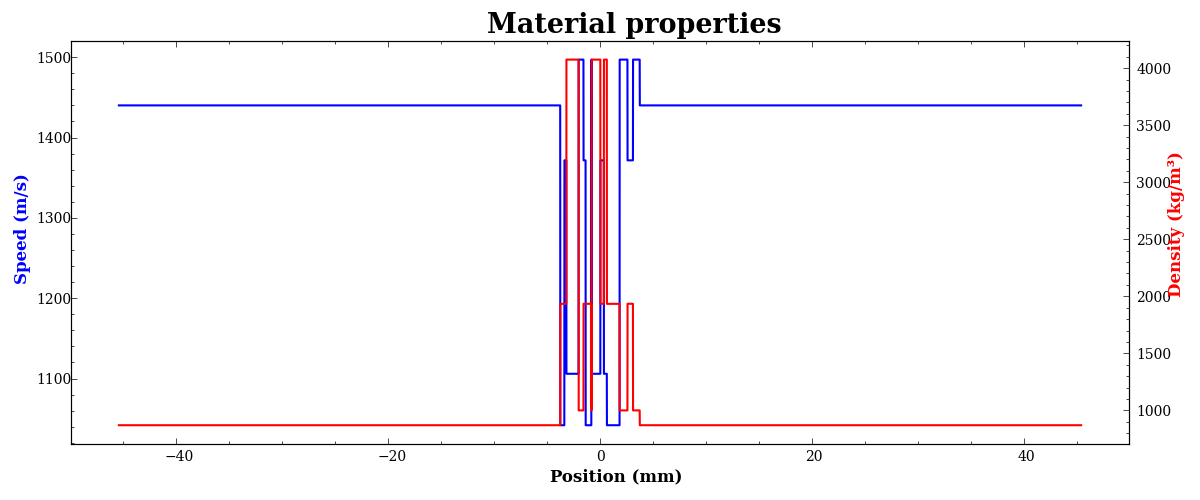

In [9]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots()
    ax.plot( x_grid*1.e3, speed_map, 'b' )
    ax.set_xlabel( 'Position (mm)' )
    ax.set_ylabel( 'Speed (m/s)', color='b' )

    ax2 = ax.twinx()
    ax2.plot( x_grid*1.e3, density_map, 'r' )
    ax2.set_ylabel( 'Density (kg/m³)', color='r' )
    plt.title( 'Material properties' )
    plt.tight_layout()


In [10]:
domain = Domain( ( x_grid.size, ), dx=( float( dx ), ) )
speed_field = FourierSeries( jnp.expand_dims( speed_map, axis=-1 ), domain=domain )
density_field = FourierSeries( jnp.expand_dims( density_map, axis=-1 ), domain=domain )

speed_field_bare = FourierSeries( jnp.expand_dims( material_properties[ 'oil' ][0]*np.ones( speed_map.size ), axis=-1 ), domain=domain )
density_field_bare = FourierSeries( jnp.expand_dims( material_properties[ 'oil' ][1]*np.ones( speed_map.size ), axis=-1 ), domain=domain )


medium = Medium(domain=domain, sound_speed=speed_field, density=density_field, pml_size=int( pml_size ), attenuation=0.95 )
medium_bare = Medium(domain=domain, sound_speed=speed_field_bare, density=density_field_bare, pml_size=int( pml_size ), attenuation=0.95 )

# Time domain

2025-09-25 16:05:01 - jwave [INFO]: Pulse period: 1.000e+00 µs
2025-09-25 16:05:01 - jwave [INFO]: Time step size: 2.362e-03 µs
2025-09-25 16:05:01 - jwave [INFO]: Number of time steps: 42334.0
2025-09-25 16:05:01 - jwave [INFO]: Sample points per period: 423.34


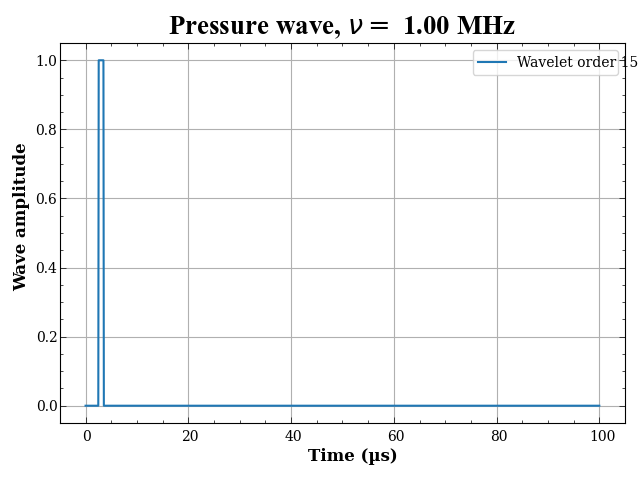

In [11]:
period = 1. / pulse_frequency
time_axis = TimeAxis.from_medium( medium, cfl=cfl )
time_axis.t_end = simulation_time
if int( time_axis.Nt )%2: 
    time_axis.t_end = simulation_time + time_axis.dt
logger.info( f'Pulse period: {period*1.e6:.3e} µs' )
logger.info( f'Time step size: {time_axis.dt*1.e6:.3e} µs' )
logger.info( f'Number of time steps: {time_axis.Nt}' )
logger.info( f'Sample points per period: {period/time_axis.dt:.2f}' )

t = time_axis.dt * np.arange( int( time_axis.Nt ) )

# mystery pulse
# craft a pulse of the correct frquency
# test_spread = 1.e-6
# pulse_location = 3. * period # this is a bit of trial and error
# t_shift = t - pulse_location
# chi = t_shift / test_spread
# test_pulse = pulse.MysteryPulse( t, pulse_location, test_spread, order=pulse_order )
# peaks = spsig.find_peaks( test_pulse, prominence=np.abs( test_pulse ).max()/20. )[0] # peak locations only
# T = ( t[ peaks[1:] ] - t[ peaks[:-1] ] ).mean()
# new_spread = test_spread * ( period/T )
# init = pulse.MysteryPulse( t, pulse_location, new_spread, order=pulse_order ) # this is the final pulse of desired frequency
# init /= init.max()

# # square pulse
pulse_location = 3. * period # this is a bit of trial and error
init = pulse.Square( t, pulse_location, 1.e-6, edge_type='cosine' )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure()
    plt.plot( t/1.e-6, init, label=f'Wavelet order {pulse_order}' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Time (µs)' )
    plt.ylabel( 'Wave amplitude' )
    plt.title( f'Pressure wave, $\\nu =$ {pulse_frequency/1.e6:.2f} MHz' )
    plt.tight_layout()

sources = Sources( 
    positions=( [ np.argmin( np.abs( x_grid - pulse_spatial_location ) ) ], ), 
    signals=jnp.stack( [ init ] ), 
    dt = time_axis.dt, 
    domain=domain
)

# Sensors

In [12]:
xloc = [ np.argmin( np.abs( x_grid - interface_locations[n] ) ) for n in [ 0, -1 ] ]
sensor_positions = ( xloc, )
sensors = Sensors( positions=sensor_positions )

In [13]:
if store_full_simulation:
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources )
    @jit
    def compiled_simulator_bare( sources ):
        return simulate_wave_propagation( medium_bare, time_axis, sources=sources )
else: 
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources, sensors=sensors )
    @jit
    def compiled_simulator_bare( sources ):
        return simulate_wave_propagation( medium_bare, time_axis, sources=sources, sensors=sensors )


# Run the simulation

In [14]:
pressure = compiled_simulator( sources=sources )
pres = np.squeeze( pressure.on_grid ) if store_full_simulation else np.squeeze( pressure )
logger.info( f'Simulation size: {pres.shape}' )
pmax = min( np.abs( pres.min() ), np.abs( pres.max() ) )
pmin = -pmax

# run the simulation without the structure to obtain the incident wave
pressure_bare = compiled_simulator_bare( sources=sources )
pres_bare = np.squeeze( pressure_bare.on_grid ) if store_full_simulation else np.squeeze( pressure_bare )

2025-09-25 16:05:02 - jwave [INFO]: Simulation size: (42334, 7700)


In [15]:
print( pmin, pmax )

-1.2272961 1.2272961


interactive(children=(IntSlider(value=0, description='Frame:', max=42333), Output()), _dom_classes=('widget-in…

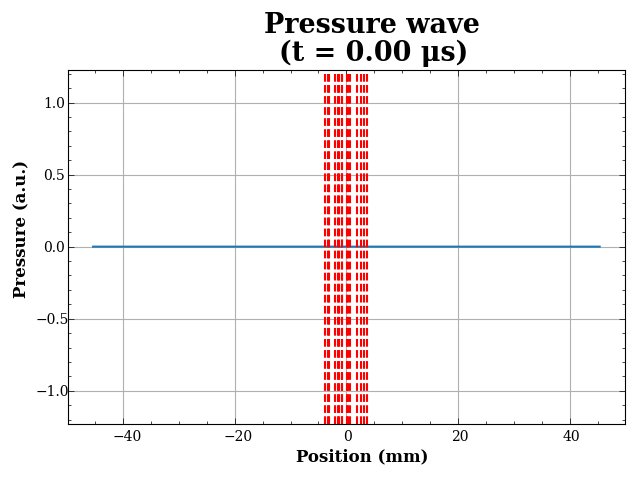

In [16]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    fig = plt.figure()
    ax = fig.subplots()
    line, = ax.plot( x_grid*1.e3, pres[0] )
    ax.set_ylim( [ pmin, pmax ] )
    ax.grid()
    ax.set_xlabel( 'Position (mm)' )
    ax.set_ylabel( 'Pressure (a.u.)' )
    titl = ax.set_title( f'Pressure wave\n(t = 0.00 μs)' )
    for loc in interface_locations: 
        ax.vlines( x=loc*1.e3, ymin=pmin, ymax=pmax, color='r', linestyle='--' )
    plt.tight_layout()

def Update( n ):
    line.set_ydata( pres[n] )
    titl.set_text( f'Pressure wave\n(t = {t[n]/1.e-6:.2f} μs)' )
    fig.canvas.draw_idle()

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=pres.shape[0] - 1,
    step=1,
    description='Frame:',
    continuous_update=True
)
interactive_plot = interactive( Update, n=slider )
display( interactive_plot )

# Post-simulation analysis

In [17]:
idx_ref = int( pulse_spatial_location > 0 )
idx_trn = int( pulse_spatial_location < 0 )
print( idx_ref, idx_trn )

wave_incident = pres_bare[:,xloc[idx_ref]]
wave_sensor1 = pres[:,xloc[idx_ref]] 
wave_transmitted = pres[:,xloc[idx_trn]]
wave_reflected = wave_sensor1 - wave_incident

0 1


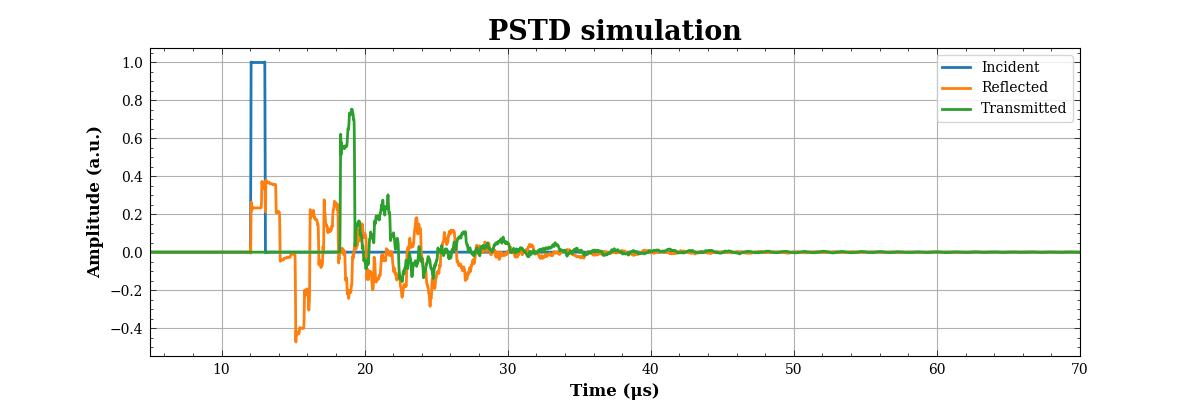

In [18]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 4 ) )
    plt.plot( t/1.e-6, wave_incident, label='Incident', linewidth=2 )
    plt.plot( t/1.e-6, wave_reflected, label='Reflected', linewidth=2 )
    plt.plot( t/1.e-6, wave_transmitted, label='Transmitted', linewidth=2 )
    plt.xlim( [ 5., 70. ] )
    plt.xlabel( 'Time (μs)' )
    plt.ylabel( 'Amplitude (a.u.)' )
    plt.grid()
    plt.legend()
    plt.title( 'PSTD simulation' )

# Harmonic (Fourier) analysis

In [19]:
freqs = npft.fftfreq( len( wave_incident ), d=time_axis.dt )
freqs = freqs[ freqs >= 0. ] 
df = ( freqs[1:] - freqs[:-1] ).mean()
freqs = np.array( list( freqs ) + [ freqs[-1] + df ] )

fwav_inc = npft.rfft( wave_incident, norm='ortho' )
fwav_ref = npft.rfft( wave_reflected, norm='ortho' )
fwav_trn = npft.rfft( wave_transmitted, norm='ortho' )

logger.info( f'Fourier components\t= {freqs.size}' )
logger.info( f'Frequency step\t= {df:.3e}' )

2025-09-25 16:05:14 - jwave [INFO]: Fourier components	= 21168
2025-09-25 16:05:14 - jwave [INFO]: Frequency step	= 1.000e+04


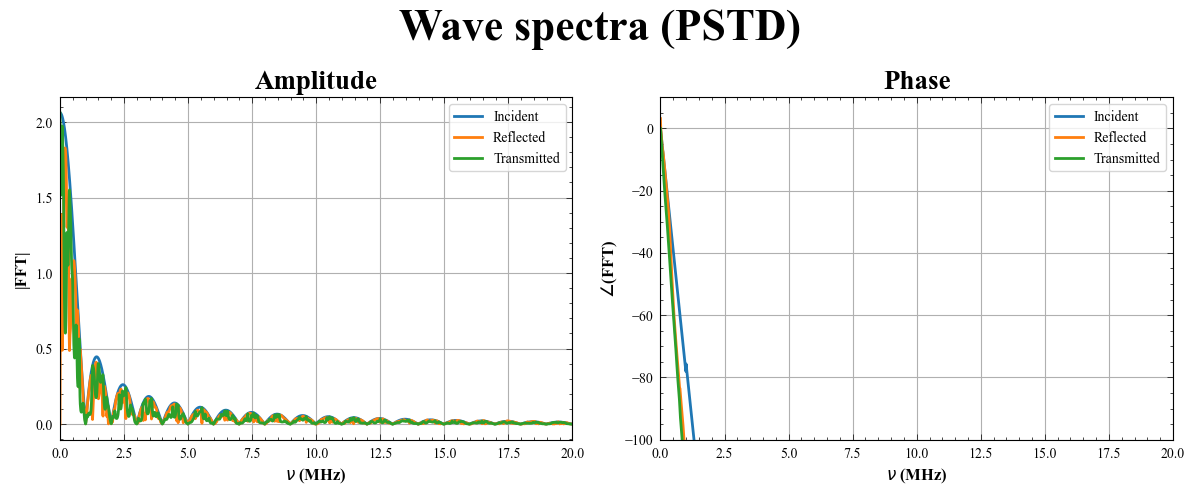

2025-09-25 16:05:14 - jwave [INFO]: Incident spectrum total energy = 3.3345343e+05
2025-09-25 16:05:14 - jwave [INFO]: Reflected spectrum total energy = 1.6556898e+05
2025-09-25 16:05:14 - jwave [INFO]: Transmitted spectrum total energy = 1.6795283e+05
2025-09-25 16:05:14 - jwave [INFO]: Energy conservation error = 2.0504986e-02%


In [20]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[0].plot( freqs[:wav.size]/1.e6, np.abs( wav ), label=lbl, linewidth=2 )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( '$\\nu$ (MHz)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 20./( period/1.e-6 ) ] )
    
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[1].plot( freqs[:wav.size]/1.e6, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( '$\\nu$ (MHz)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra (PSTD)' )
    plt.tight_layout()
    plt.show()

Ef = []
for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2.*np.pi ) # trapezoidal integration
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )


## S-matrix reconstruction

In [21]:
inputs = np.concatenate( [ arr[np.newaxis,:] for arr in [ fwav_inc, np.zeros( fwav_inc.shape ) ] ], axis=0 )
if idx_ref:
    inputs = inputs[::-1,:]
speed, density = zip( *[ [ speeds[n], densities[n] ] for n in stack_definition ] )
Z = np.array( [ s*d for s, d in zip( speed, density ) ] )

# build propagator
L = interface_locations[1:] - interface_locations[:-1]
L = [ 0. ] + list( L ) # 0. because the first interface of the stack is at the location we want to measure. 
stack_speed = [ speeds[n] for n in stack_definition[:-1] ]

if len( stack_definition )==1: 
    logger.warning( 'Single-layer stack. ' )
else: 
    logger.warning( 'Multi-layer stack. ' )
propagators = [ 
    ftools.partial( smat.SMatrix, Z=Z[n:n+2], speed=stack_speed[n], x=L[n], field=field )
    for n in range( len( L ) )
]

2025-09-25 16:05:14 - jwave [WARNING]: Multi-layer stack. 


In [22]:
all_outputs = np.zeros( ( 2, freqs.size ), dtype=complex )
start_time = time.time()
for n, omega_test in enumerate( 2.*np.pi*freqs ):
    S = ftools.reduce( lambda x, y: x*y, [ prop( omega=omega_test ) for prop in propagators ] )
    # print( S.Z )
    output = S.S @ inputs[:,n][:,np.newaxis]
    all_outputs[:,n] = output.squeeze()

elapsed_time = time.time() - start_time
logger.info( f'S-matrix simulation took {elapsed_time:.6f} seconds to reconstruct {freqs.size} Fourier components. ' )

2025-09-25 16:05:22 - jwave [INFO]: S-matrix simulation took 7.481120 seconds to reconstruct 21168 Fourier components. 


In [23]:
idx_ref, idx_trn

(0, 1)

2025-09-25 16:05:22 - jwave [INFO]: Incident spectrum total energy = 3.3345343e+05
2025-09-25 16:05:22 - jwave [INFO]: Reflected spectrum total energy = 1.6579907e+05
2025-09-25 16:05:22 - jwave [INFO]: Transmitted spectrum total energy = 1.6765437e+05
2025-09-25 16:05:22 - jwave [INFO]: Energy conservation error = 1.5453627e-06%
2025-09-25 16:05:22 - jwave [INFO]: Energy conservation error (in multiples of machine zero) = 69596949.349374443292618


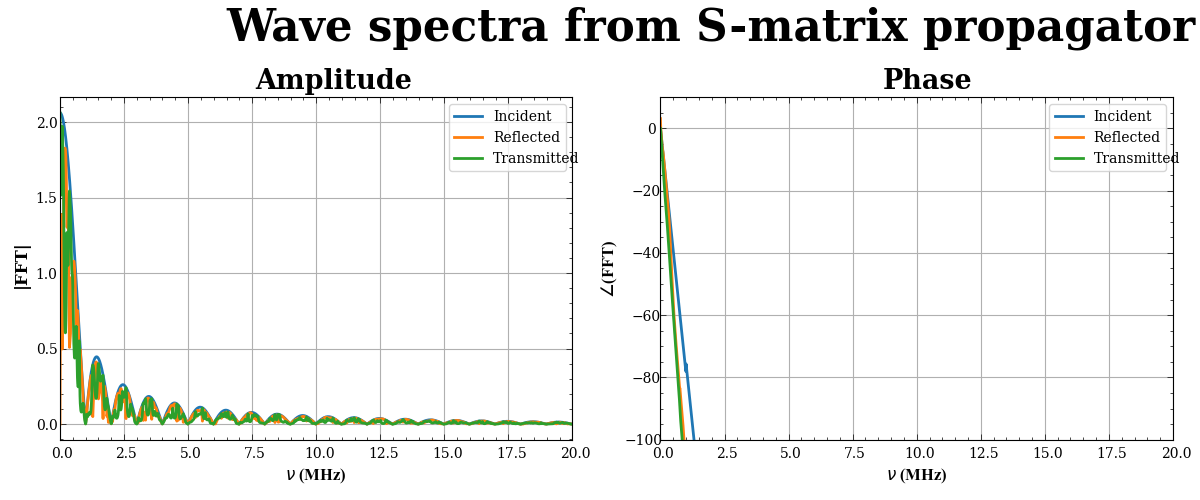

In [24]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    lbls = [ 'Incident', 'Reflected', 'Transmitted' ]
    for wav, lbl in zip( [ fwav_inc, all_outputs[idx_trn], all_outputs[idx_ref] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[0].plot( freqs/1.e6, np.abs( wav )[:freqs.size], label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( '$\\nu$ (MHz)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 20./( period/1.e-6 ) ] )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[idx_trn], all_outputs[idx_ref] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[1].plot( freqs/1.e6, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( '$\\nu$ (MHz)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra from S-matrix propagator' )
    plt.tight_layout()
    
df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for wav, lbl in zip( [ fwav_inc[:-1], all_outputs[idx_trn], all_outputs[idx_ref] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2. * np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )

plt.show()

# Simulated waveforms from S-matrix
Compare these to the simulated waveforms plotted earlier. 

In [25]:
back = npft.irfft( fwav_inc, norm='ortho' )
back_r = npft.irfft( all_outputs[idx_trn], norm='ortho' )
back_t = npft.irfft( all_outputs[idx_ref], norm='ortho' )

2025-09-25 16:05:22 - jwave [INFO]: Incident energy	= 9.898e-07
2025-09-25 16:05:22 - jwave [INFO]: Reflected energy	= 4.922e-07
2025-09-25 16:05:22 - jwave [INFO]: Transmitted energy	= 4.977e-07


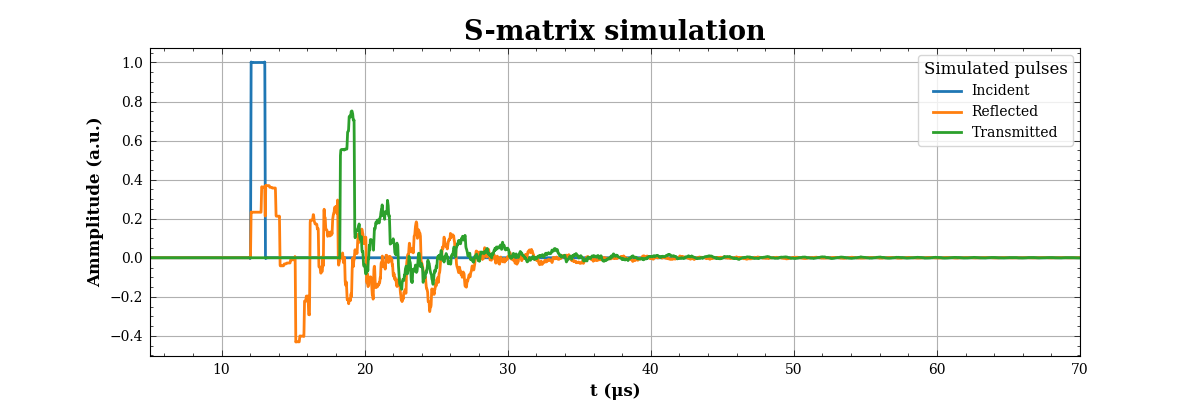

In [26]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 4 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = time_axis.dt*( np.abs( wav )**2 ).sum()
        # energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t[:wav.size]/1.e-6, wav, label=lbl, linewidth=2 )
    plt.xlim( [ 5., 70. ] )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'S-matrix simulation' )
    plt.xlabel( 't (μs)' )
    plt.ylabel( 'Ammplitude (a.u.)' )

# Comparison plots

2025-09-25 16:05:23 - jwave [INFO]: Incident error: 2.630e-08
2025-09-25 16:05:23 - jwave [INFO]: Reflected error: 2.139e-03
2025-09-25 16:05:23 - jwave [INFO]: Transmitted error: 1.744e-03


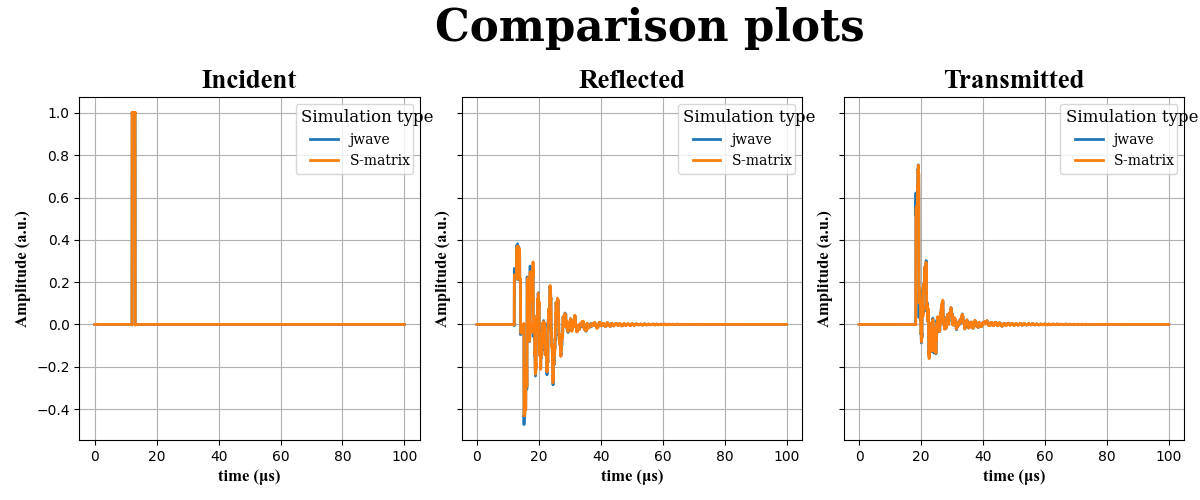

In [27]:
fig = plt.figure( figsize=( 12, 5 ) )
ax = fig.subplots( 1, 3, sharex=True, sharey=True )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    for n, ( wav1, wav2, lbl ) in enumerate( zip( [ wave_incident, wave_reflected, wave_transmitted ], [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[n].plot( t/1.e-6, wav1, label='jwave', linewidth=2 )
        ax[n].plot( t/1.e-6, wav2, label='S-matrix', linewidth=2 )
        ax[n].set_xlabel( 'time (μs)', weight='bold', fontname='Times New Roman', fontsize=12  )
        ax[n].set_ylabel( 'Amplitude (a.u.)', weight='bold', fontname='Times New Roman', fontsize=12 )
        ax[n].grid()
        ax[n].legend().set_title('Simulation type' )
        ax[n].set_title( f'{lbl}', fontname='Times New Roman', fontsize=19.4 )
        logger.info( f'{lbl} error: {np.abs( wav1-wav2 ).sum()/np.array( wav1 ).size:.3e}' )
    fig.suptitle( 'Comparison plots' )
    fig.tight_layout()

# Lambdification
With larger simulation times and domains, the S-matrix simulation shown above starts to take longer than the `jwave` simulation, which is undesirable.  
This inefficiency stems from the repeated calculation of _all_ the constituent S-matrices for the entire stack at each frequency, prior to composing them with the Redheffer product. 
A large part of these calculations are redundant because the only changing S-matrix parameter is the angular frequency $\omega$ itself (at least in the simple, non-dispersive treatment). 

The following section demonstrates how speedup can be achieved in this regard by creating a Python _function_ of frequency from the theoretical S-matrix. 
In particular, the methods `SMatrix.BuildSymbolic` creates an equivalent symbolic S-matrix in SymPy and then from it, a Python lambda function of frequency (and other user-defined parameters). This internal method `SMatrix.Evaluate` is C-optimized internally and is therefore extremely fast. 

Currently, the entire S-matrix is symbolized  (_i.e._, converted to symbolic form in SymPy) but only the `S[0,0]` matrix element is lambdified. This matrix element, when viewed as a function of $\omega$, is in fact the (frequency-domain) transfer function of the stack and corresponds directly to the measurement made by the Echostat `Rx` in the thru-wave geometry. More matrix elements will be lambdified in future iterations of the Python code, as and when required. 

In [28]:
S.BuildSymbolic( cse=True )

[W 250925 16:05:23 smatrix:122] Absorption not yet implemented in symbolic matrix. 


Composing S-matrices:   0%|          | 0/15 [00:00<?, ?it/s]

[I 250925 16:05:24 smatrix:144] Applying common sub-expression elimination...


# Intermediate symbols
The optimized lambdification makes liberal use of intermediate symbols internally to avoid re-calculating the same expression multiple times. These are printed below. This list can get quite large depending on the complexity of the user-defined stack.  

In [29]:
S.M_replacement_00 # '00' stands for the (0,0) matrix element

[(x0, I*omega),
 (x1, t1*x0),
 (x2, t10*x0),
 (x3, t11*x0),
 (x4, t12*x0),
 (x5, t13*x0),
 (x6, t14*x0),
 (x7, t2*x0),
 (x8, t3*x0),
 (x9, t4*x0),
 (x10, t5*x0),
 (x11, t6*x0),
 (x12, t7*x0),
 (x13, t8*x0),
 (x14, t9*x0),
 (x15, R10*exp(-2*x1)),
 (x16, R12*x15 - 1),
 (x17, 1/x16),
 (x18, T12*T21*x15),
 (x19, R21 - x17*x18),
 (x20, exp(-2*x7)),
 (x21, R23*x20),
 (x22, R21 - x18/x16),
 (x23, x21*x22 - 1),
 (x24, T23*T32*x20),
 (x25, R32 - x19*x24/x23),
 (x26, exp(-2*x8)),
 (x27, R34*x26),
 (x28, R32 - x22*x24/x23),
 (x29, x27*x28 - 1),
 (x30, T34*T43*x26),
 (x31, R43 - x25*x30/x29),
 (x32, exp(-2*x9)),
 (x33, R45*x32),
 (x34, R43 - x28*x30/x29),
 (x35, x33*x34 - 1),
 (x36, T45*T54*x32),
 (x37, R54 - x31*x36/x35),
 (x38, exp(-2*x10)),
 (x39, R56*x38),
 (x40, R54 - x34*x36/x35),
 (x41, x39*x40 - 1),
 (x42, T56*T65*x38),
 (x43, R65 - x37*x42/x41),
 (x44, exp(-2*x11)),
 (x45, R67*x44),
 (x46, R65 - x40*x42/x41),
 (x47, x45*x46 - 1),
 (x48, T67*T76*x44),
 (x49, R76 - x43*x48/x47),
 (x50, exp(

# The transfer function
Below is the closed-form expression of the transfer function of the physical stack, in terms of the frequency $\omega$, reflection/transmission coefficients and the aforementioned intermediate expressions. 

In [30]:
S.M_reduced_00[0]

T01*T1011*T1112*T12*T1213*T1314*T1415*T23*T34*T45*T56*T67*T78*T89*T910*x17*exp(-x1)*exp(-x10)*exp(-x11)*exp(-x12)*exp(-x13)*exp(-x14)*exp(-x2)*exp(-x3)*exp(-x4)*exp(-x5)*exp(-x6)*exp(-x7)*exp(-x8)*exp(-x9)*exp(-t0*x0)/((x19*x21 - 1)*(x25*x27 - 1)*(x31*x33 - 1)*(x37*x39 - 1)*(x43*x45 - 1)*(x49*x51 - 1)*(x55*x57 - 1)*(x61*x63 - 1)*(x67*x69 - 1)*(x73*x75 - 1)*(x79*x81 - 1)*(x85*x87 - 1)*(R1415*(R1413 - T1314*T1413*x85*x86/(x87*(R1312 - x82*x84/x83) - 1))*exp(-2*x6) - 1))

# Payload
Now building the numerical "payload", which is a dictionary containing the arguments to the lambdified function. This function has the flexibility of accepting all possible stack parameters, including frequency, times of flight through each layer, reflection and transmission coefficients. If the user desires a function of frequency only, it can easily be created externally in Python using `functools.partial`. 

In [31]:
om = 0.
times = np.array( [ l/v for l, v in zip( L, speed[:-1] ) ] ) # times of flight for the stack layers
denominator = Z[:-1] + Z[1:]
T_forw = 2.*Z[:-1] / denominator
T_back = 2.*Z[1:] / denominator
R_forw = ( Z[1:] - Z[:-1] ) / denominator
R_back = -R_forw
input_numerical_args = np.concatenate( ( ( om, ), times, T_forw, T_back, R_forw, R_back ) )
payload = { key:val for key, val in zip( [ str(var) for var in S.syms ], list( input_numerical_args ) ) }
payload


{'omega': np.float64(0.0),
 't0': np.float64(0.0),
 't1': np.float64(3.6957884453206835e-07),
 't2': np.float64(1.417045210380428e-07),
 't3': np.float64(1.0496628590267507e-06),
 't4': np.float64(3.0555904935602074e-07),
 't5': np.float64(1.4496584019299225e-07),
 't6': np.float64(5.136032863707097e-07),
 't7': np.float64(1.8336993828135343e-08),
 't8': np.float64(7.442819692818734e-07),
 't9': np.float64(2.4654290634705295e-07),
 't10': np.float64(2.519674195797214e-07),
 't11': np.float64(1.1518450837801047e-06),
 't12': np.float64(4.969132294067093e-07),
 't13': np.float64(3.77339346355509e-07),
 't14': np.float64(4.2721213740470995e-07),
 'T01': np.float64(0.7667746236703914),
 'T12': np.float64(0.8632371560560074),
 'T23': np.float64(0.7411950357255558),
 'T34': np.float64(1.5012760702937018),
 'T45': np.float64(0.7213831705498719),
 'T56': np.float64(1.1367628439439927),
 'T67': np.float64(1.1474733743717724),
 'T78': np.float64(0.4987239297062981),
 'T89': np.float64(1.25880496

Now evaluating the frequency-domain transfer function and using it to compute the transmitted waveform. 

In [32]:
payload[ 'omega' ] = 2.*np.pi*freqs # since the function is fully vectorized
start = time.time()
transfer_function = S.Evaluate( **payload )
wav_transmitted_lambdified = npft.irfft( fwav_inc * transfer_function, norm='ortho' )
stop = time.time()
logger.info( f'Time taken to compute transmitted wave using lambdified function = {stop-start:.6f} seconds. ' )

2025-09-25 16:05:57 - jwave [INFO]: Time taken to compute transmitted wave using lambdified function = 0.025266 seconds. 


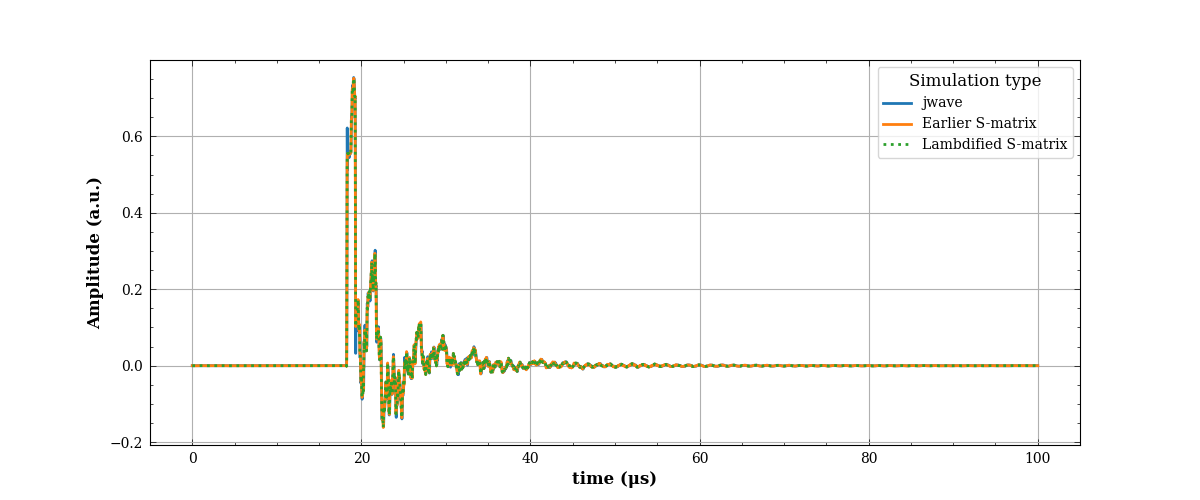

In [36]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    plt.plot( t/1.e-6, wave_transmitted, label='jwave', linewidth=2 )
    plt.plot( t/1.e-6, back_t, label='Earlier S-matrix', linewidth=2 )
    plt.plot( t/1.e-6, wav_transmitted_lambdified, ':', label='Lambdified S-matrix', linewidth=2 )
    plt.xlabel( 'time (μs)' )
    plt.ylabel( 'Amplitude (a.u.)' )
    plt.legend( title='Simulation type' )
    plt.grid()

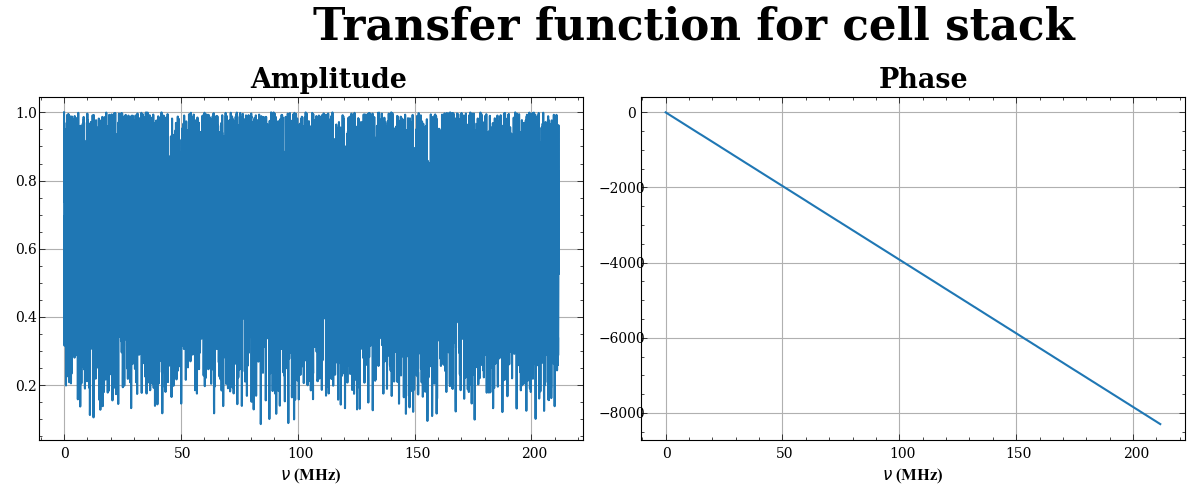

In [ ]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )

    ax[0].plot( freqs/1.e6, np.abs( transfer_function ) )
    ax[1].plot( freqs/1.e6, np.unwrap( np.angle( transfer_function ) ) )

    for n, ttl  in enumerate( [ 'Amplitude', 'Phase' ] ):
        ax[n].grid()
        ax[n].set_xlabel( '$\\nu$ (MHz)' )
        ax[n].set_title( ttl )
    plt.suptitle( 'Transfer function for cell stack' )
    plt.tight_layout()

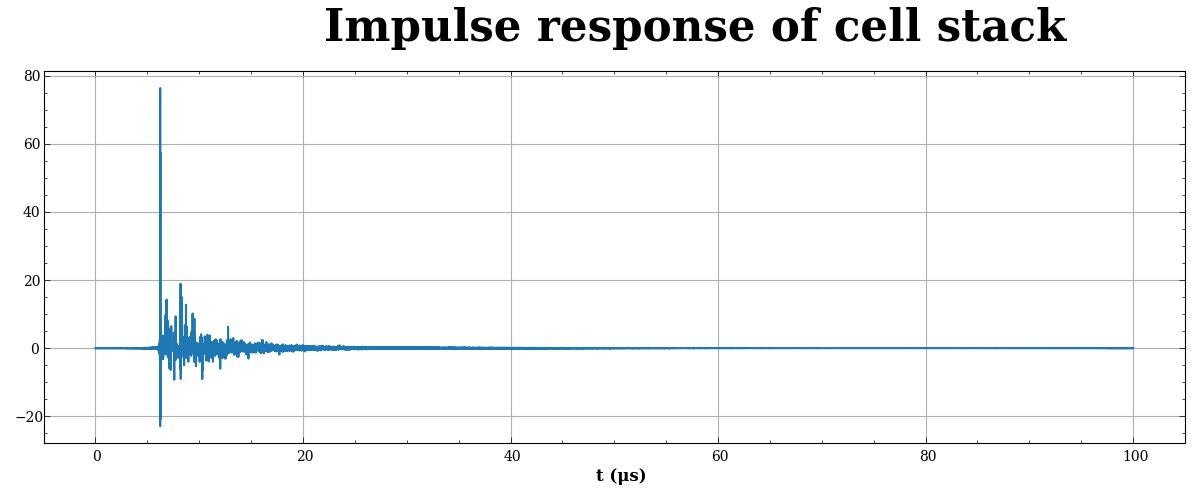

In [42]:
impulse_response = npft.irfft( transfer_function, norm='ortho' )
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots()

    ax.plot( t/1.e-6, impulse_response )
    ax.grid()
    ax.set_xlabel( 't (μs)' )
    plt.suptitle( 'Impulse response of cell stack' )
    plt.tight_layout()